/home/andres/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:938: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Dice coefficient: 0.5798387466275307 +- 0.22463004587306878

Precision: 0.5325651243587882 +- 0.2972713107758949

Recall: 0.7858914362428476 +- 0.21565423195044883



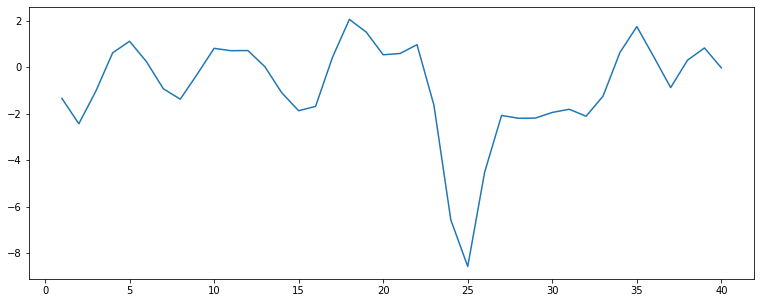

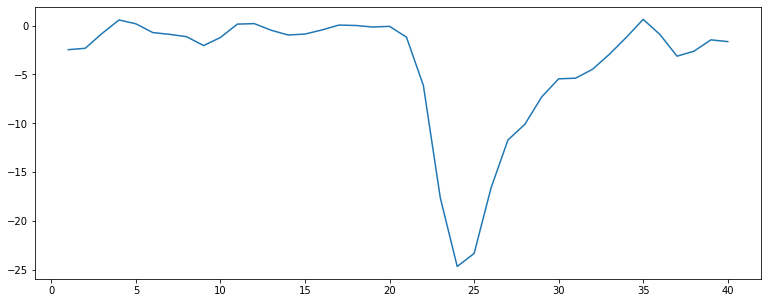

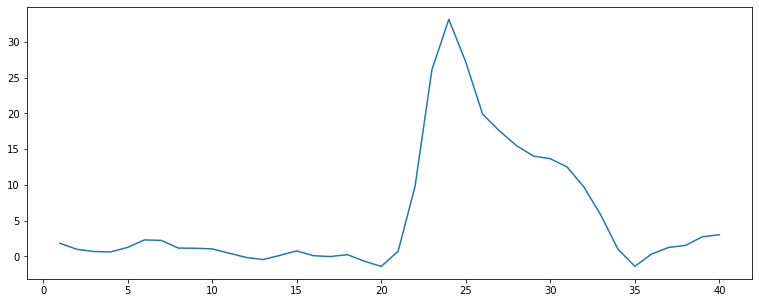

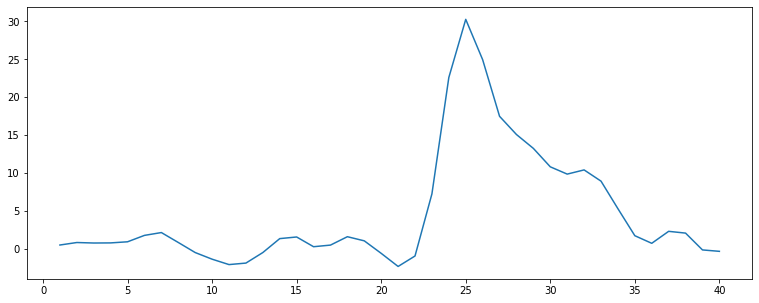

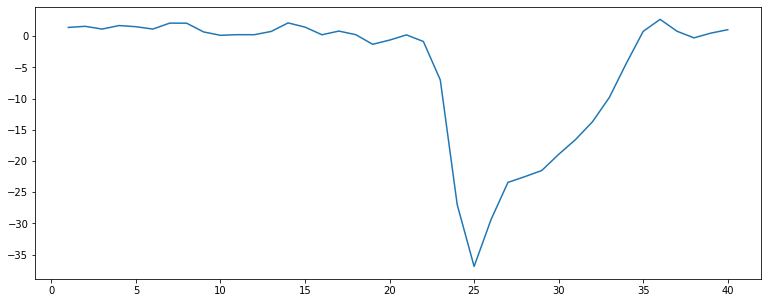

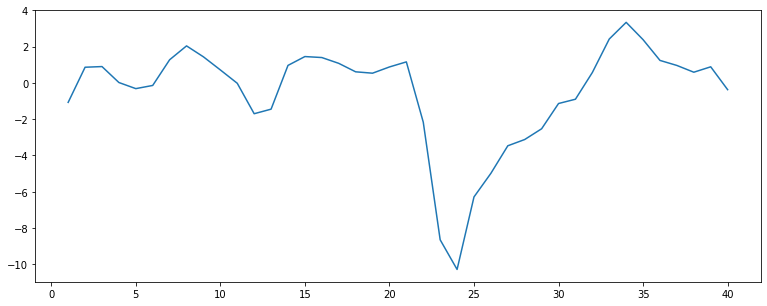

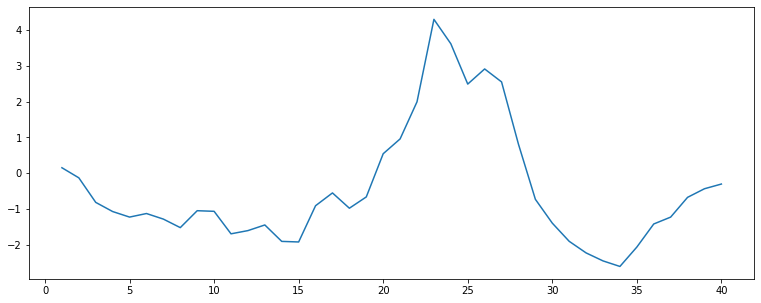

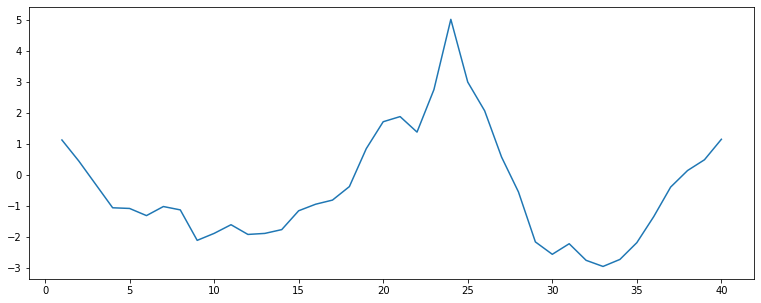

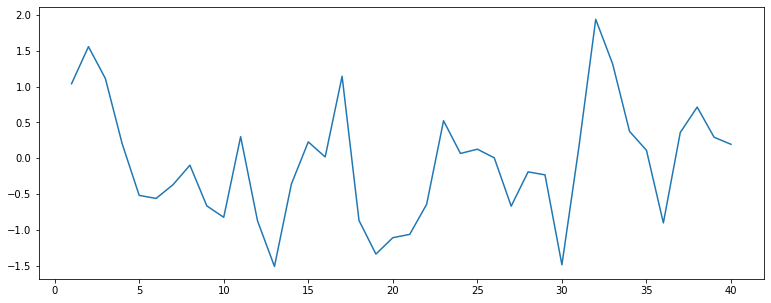

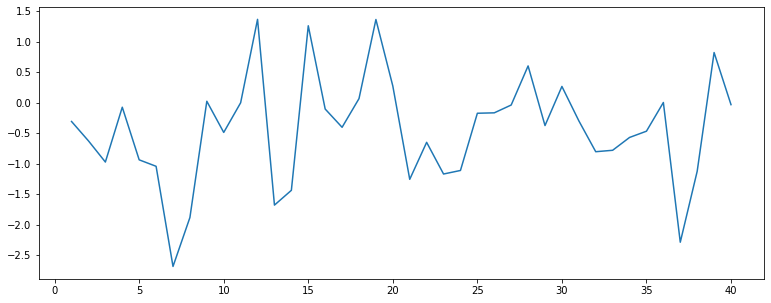

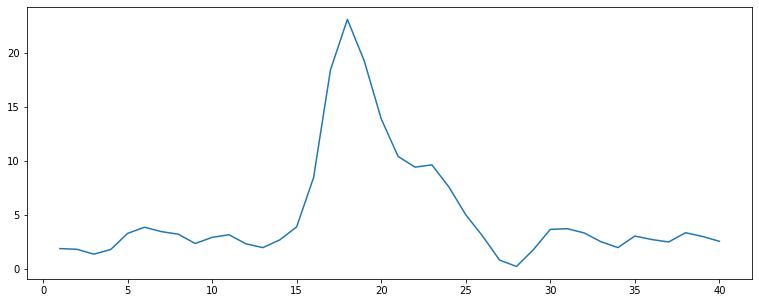

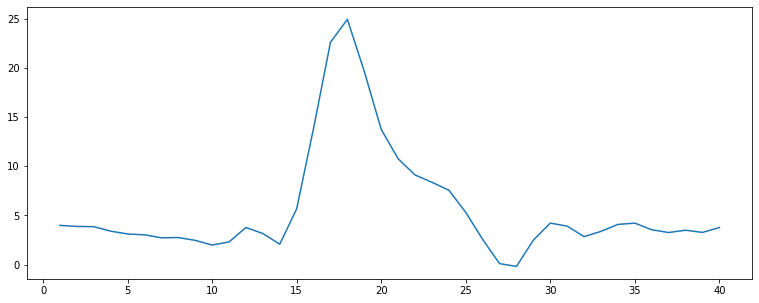

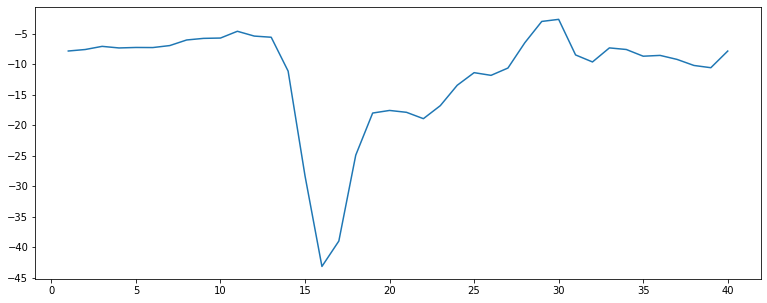

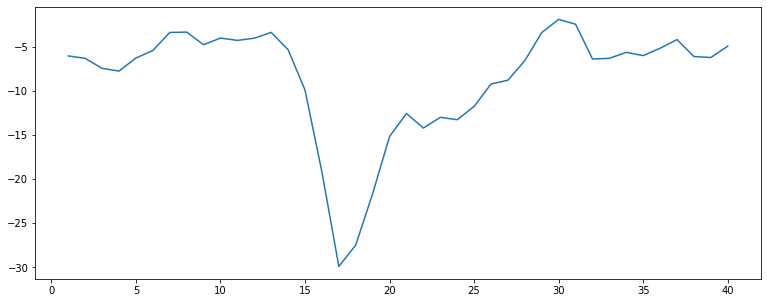

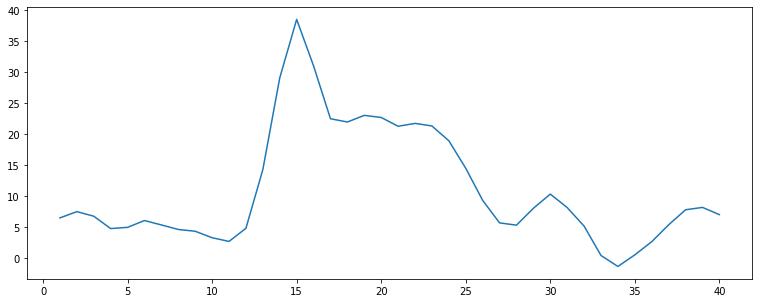

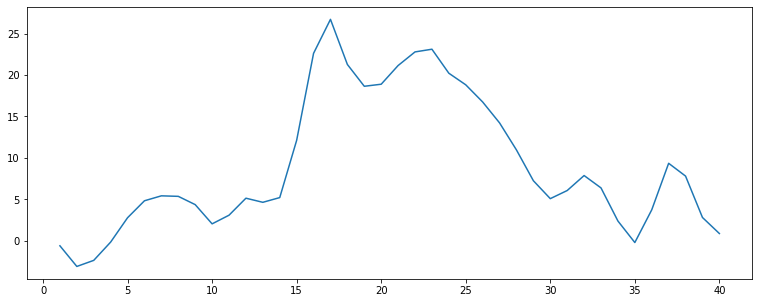

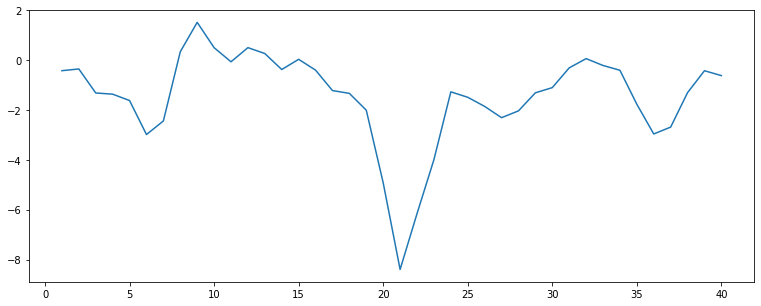

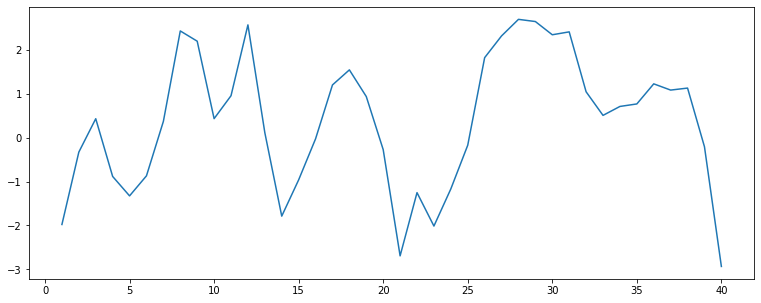

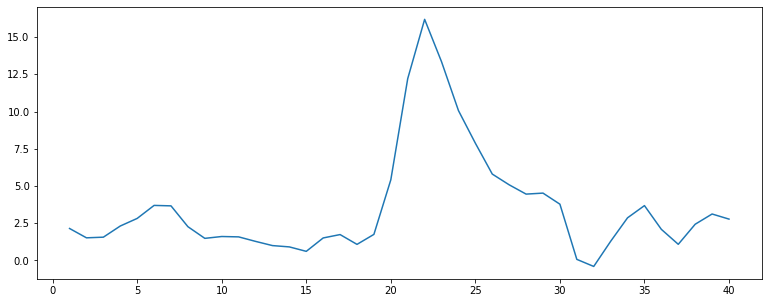

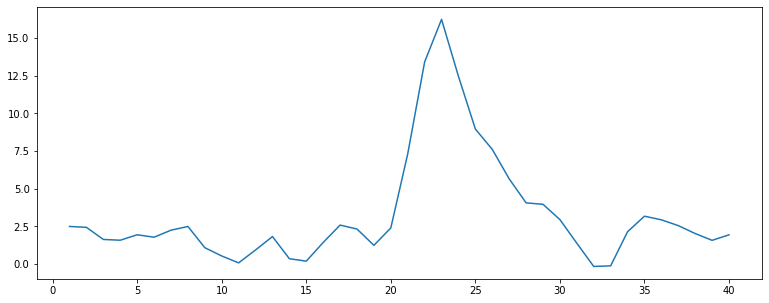

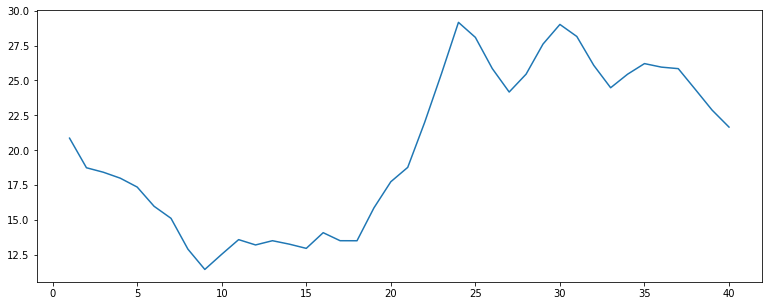

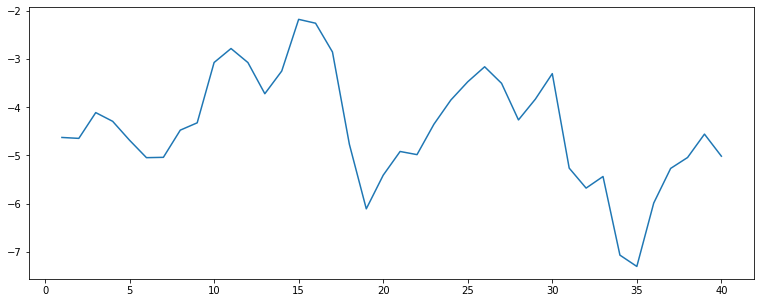

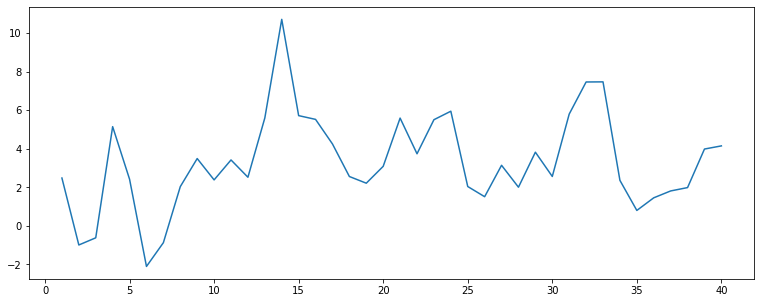

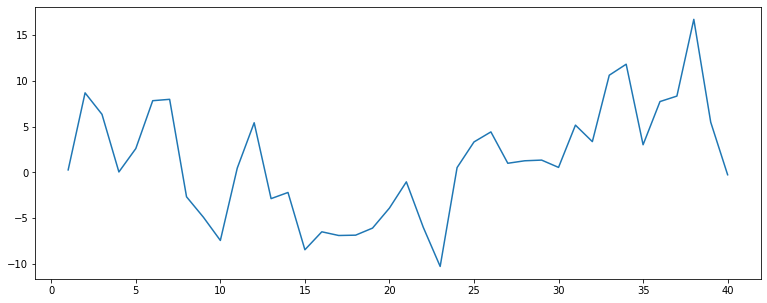

In [25]:
import sys

import os

import time

import torch

import numpy as np

import matplotlib.pyplot as plt

import params

import utilities

import torch.optim as optim

import models

import pandas as pd

import vtk

from vtk.util.numpy_support import numpy_to_vtk, vtk_to_numpy

from flowInformation import FlowInfo

from torch.autograd import Variable

from evaluate import Dice, Precision, Recall

import cv2

from test import testing

import evaluate

from datasets import QFlowDataset

import models

import re


def testing_dataLoader(test_path):
    
    """
    Data loader providing raw file and mask paths for model testing
    
    Params:
    
        - test_path: folder where to start looking for all files
        
        
    Returns:
    
        - raw_paths: list with paths for raw files
        
        - mask_paths: list with paths for mask files
        
        - total_patients: list with testing patients in 2D models
    
    """

    raw_paths = []

    mask_paths = []
    
    total_patients = []

    if params.three_D or (not(params.three_D) and params.add3d > 0):

        if not('ckd1' in test_path):

            studies = sorted(os.listdir(test_path))

            for study in studies:

                if study != '_ckd1':

                    study_path = test_path + study + '/'

                    patients = sorted(os.listdir(study_path))

                    for patient in patients:

                        image_path = study_path + patient + '/'

                        images = sorted(os.listdir(image_path))

                        if not('BF' in params.train_with):

                            if params.train_with == 'mag_' or params.train_with == 'both':

                                ind_raw = [i for i,s in enumerate(images) if 'mag_' in s]

                            elif params.train_with == 'pha':

                                ind_raw = [i for i,s in enumerate(images) if 'pha' in s]

                            ind_msk = [i for i,s in enumerate(images) if 'msk' in s]

                            for ind_r, ind_m in zip(ind_raw, ind_msk):

                                raw_paths.append(image_path + images[ind_r])

                                mask_paths.append(image_path + images[ind_m])


                        else:

                            ind_raw = [i for i,s in enumerate(images) if 'magBF' in s]

                            ind_msk = [i for i,s in enumerate(images) if 'msk' in s]

                            for ind_r, ind_m in zip(ind_raw, ind_msk):

                                raw_paths.append(image_path + images[ind_r])

                                mask_paths.append(image_path + images[ind_m])


        else:

            patients = sorted(os.listdir(test_path))

            for patient in patients:

                if not('CKD015' in patient):

                    image_path = test_path + patient + '/'

                    images = sorted(os.listdir(image_path))

                    if not('BF' in params.train_with):

                        if params.train_with == 'mag_' or params.train_with == 'both':

                            ind_raw = [i for i,s in enumerate(images) if 'mag_' in s]

                        elif params.train_with == 'pha':

                            ind_raw = [i for i,s in enumerate(images) if 'pha' in s]

                        ind_msk = [i for i,s in enumerate(images) if 'msk' in s]

                        for ind_r, ind_m in zip(ind_raw, ind_msk):

                            raw_paths.append(image_path + images[ind_r])

                            mask_paths.append(image_path + images[ind_m])


                    else:

                        ind_raw = [i for i,s in enumerate(images) if 'magBF' in s]

                        ind_msk = [i for i,s in enumerate(images) if 'msk' in s]

                        for ind_r, ind_m in zip(ind_raw, ind_msk):

                            raw_paths.append(image_path + images[ind_r])

                            mask_paths.append(image_path + images[ind_m])



    else:

        if not('ckd1' in test_path):

            studies = sorted(os.listdir(test_path))

            for study in studies:

                if study != '_ckd1':

                    study_path = test_path + study + '/'

                    patients = sorted(os.listdir(study_path))

                    for patient in patients:

                        patient_path = study_path + patient + '/' 

                        modalities = sorted(os.listdir(patient_path))

                        for modality in modalities:

                            if modality == 'msk':

                                modality_path = patient_path + modality + '/'

                                masks = sorted(os.listdir(modality_path))

                                for mask in masks:

                                    mask_paths.append(modality_path + mask)

                            if not('BF' in params.train_with):

                                if modality == 'mag':

                                    modality_path = patient_path + modality + '/'

                                    mags = sorted(os.listdir(modality_path))
                                    
                                    found = 0

                                    for mag in mags:

                                        if not('sum' in mag) and not('mip' in mag):

                                            raw_paths.append(modality_path + mag)
                                    
                                            ind_frame = mag.index('_frame')

                                            total_patients.append(mag[:ind_frame])

                            else:

                                if modality == 'magBF':

                                    modality_path = patient_path + modality + '/'

                                    mags = sorted(os.listdir(modality_path))
                                    
                                    found = 0

                                    for mag in mags:

                                        if not('sum' in mag) and not('mip' in mag):

                                            raw_paths.append(modality_path + mag)
                                    
                                            ind_frame = mag.index('_frame')

                                            total_patients.append(mag[:ind_frame])

                            total_patients = np.unique(np.array(total_patients)).tolist()

        else:

            patients = sorted(os.listdir(test_path))

            for patient in patients:

                if not('CKD015' in patient):

                    patient_path = test_path + patient + '/'

                    modalities = sorted(os.listdir(patient_path))

                    for modality in modalities:        

                        if not('BF' in params.train_with):

                            if modality == 'mag':

                                modality_path = patient_path + modality + '/'

                                mags = sorted(os.listdir(modality_path))

                                for mag in mags:

                                    if not('sum' in mag) and not('mip' in mag):

                                        raw_paths.append(modality_path + mag)
                                        
                                        ind_frame = mag.index('_frame')

                                        total_patients.append(mag[:ind_frame])

                        else:

                            if modality == 'magBF':

                                modality_path = patient_path + modality + '/'

                                mags = sorted(os.listdir(modality_path))

                                for mag in mags:

                                    if not('sum' in mag) and not('mip' in mag):

                                        raw_paths.append(modality_path + mag)
                                        
                                    ind_frame = mag.index('_frame')

                                    total_patients.append(mag[:ind_frame])
                                    
                        total_patients = np.unique(np.array(total_patients)).tolist()

    return raw_paths, mask_paths, total_patients



def modelPreparation(model_path, model_filename):
        
    """
    Prepares model and optimizer to load them for inference.

    Returns: list with loaded models and optimizers

    """

    if params.architecture == "UNet_with_Residuals":

        net = models.UNet_with_Residuals().cuda()

    elif params.architecture == "UNet_with_ResidualsPretrained":

        net = UNet_with_ResidualsPretrained().cuda()


    elif params.architecture == "NewUNet_with_Residuals":

        net = models.NewUNet_with_Residuals().cuda() 

    elif params.architecture == "UNetRNN":

        net = models.UNetRNN().cuda()


    elif params.architecture == "UNet_with_ResidualsFourLayers":

        net = models.UNet_with_ResidualsFourLayers().cuda()


    elif params.architecture == "AttentionUNet":

        net = models.AttentionUNet().cuda()


    elif params.architecture == "NewAttentionUNet":

        net = models.NewAttentionUNet().cuda()


        # MORE MODELS TO COME!!!

    else:

        print('Wrong architecture. Please introduce a valid architecture')


    if params.opt == 'Adam':

        optimizer = optim.Adam(net.parameters(), params.lr)

    elif params.opt == 'RMSprop':

        optimizer = optim.RMSprop(net.parameters(), params.lr)

    elif params.opt == 'SGD':

        optimizer = optim.SGD(net.parameters(), params.lr)

    else:

        print('\nWrong optimizer. Please define a valid optimizer (Adam/RMSprop/SGD)\n')



    net, optimizer = utilities.model_loading(net, optimizer, model_path, model_filename)

    return net, optimizer


def atoi(text):
    
    """
    
    Function helping to sort a list of strings with numbers inside
    
    """
    
    return int(text) if text.isdigit() else text

def natural_keys(text):
    
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]



def Segmentation(X, out, Y):
    
    """
    Provide a segmentation VTK file with testing results of mask overlapped
    with normal raw image.

    Params:

        - X: raw image array

        - out: output tensor from neural network
        
        - Y: mask array (if unavailable, None)


    Results:

        saved VTK image in color (G: correct segmentation B: under segmentation
        R: over segmentation)


    """

    final_result = np.zeros((X.shape[0], X.shape[1], X.shape[2], 3))
    
    for i in range(final_result.shape[-1]):

        final_result[:,:,:,i] = (X-np.amin(X))/(np.amax(X)-np.amin(X)) # Grayscale values from 0 to 255




    if Y is None:

        # If no mask available, leave segmented result in green

        ind_green = np.array(np.where(out > 0.5))

        final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 0] = 0

        final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 1] = 1

        final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 2] = 0


    else:


        # If mask is available, leave coincident results in green, results with result but not with mask in red 
        # and results with mask but not with result in blue

        ind_pos_out = np.where(out > 0) # Result locations

        ind_pos_Y = np.where(Y > 0) # Mask locations

        out_aux = np.copy(out)

        Y_aux = np.copy(Y)

        out_aux[ind_pos_out] = 2 # Set result locations to 2

        Y_aux[ind_pos_Y] = 3 # Set mask locations to 3

        mult = out*Y

        ind_green = np.array(np.where(mult > 0))

        total = out_aux + Y_aux

        ind_red = np.array(np.where(total == 1))

        ind_blue = np.array(np.where(total == 3))

        # Color final mask result

        final_result[ind_red[0,:], ind_red[1,:], ind_red[2,:], 0]  = 1

        final_result[ind_red[0,:], ind_red[1,:], ind_red[2,:], 1]  = 0

        final_result[ind_red[0,:], ind_red[1,:], ind_red[2,:], 2]  = 0

        final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 0] = 0

        final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 1] = 1

        final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 2] = 0

        final_result[ind_blue[0,:], ind_blue[1,:], ind_blue[2,:], 0] = 0

        final_result[ind_blue[0,:], ind_blue[1,:], ind_blue[2,:], 1] = 0

        final_result[ind_blue[0,:], ind_blue[1,:], ind_blue[2,:], 2] = 1


    return final_result


def readVTK(filename, order='F'):
            
    """
    Utility function to read vtk volume. 

    Params:

        - inherited from class (check at the beginning of the class)
        - path: path where VTK file is located
        - filename: VTK file name

    Returns:

        - numpy array
        - data origin
        - data spacing

    """

    reader = vtk.vtkStructuredPointsReader()

    reader.SetFileName(filename)

    reader.Update()

    image = reader.GetOutput()

    numpy_array = vtk_to_numpy(image.GetPointData().GetScalars())

    numpy_array = numpy_array.reshape(image.GetDimensions(),order='F')

    numpy_array = numpy_array.swapaxes(0,1)

    origin = list(image.GetOrigin())

    spacing = list(image.GetSpacing())

    return numpy_array, origin, spacing
    
    

def MIP(X, out, Y, img_filename, dest_path):

    """
    Provide a MIP image with found result.

    Params:

        - X: raw image array

        - out: output tensor from neural network

        - mask: provided mask tensor (if unavailable: None)
        
        - img_filename: filename ID with which to save MIP image as PNG
        
        - dest_path: destination folder


    Results:

        saved PNG image in color (G: correct segmentation B: under segmentation
        R: over segmentation)


    """

    final_result = Segmentation(X, out, Y)

    mip_result = np.round(np.sum(255*final_result, axis = 0)/final_result.shape[2]).astype(int)

    # Decide on final filename

    if 'pha' in params.train_with:

        filename = img_filename.replace('pha','mip') + '.png'

    elif not('pha' in params.train_with) and not('BF' in params.train_with):

        filename = img_filename.replace('mag','mip') + '.png'

    elif not('pha' in params.train_with) and ('BF' in params.train_with):

        filename = img_filename.replace('magBF','mip') + '.png'

    # Exchange blue and red channels to write PNG file with CV2

    mip_aux = np.copy(mip_result)

    mip_aux[:,:,0] = mip_result[:,:,-1]

    mip_aux[:,:,-1] = mip_result[:,:,0]

    cv2.imwrite(dest_path + filename, mip_aux)


    
def majorityVoting(results):
        
    """
    Implement a majority voting of the results given by the different models from the cross-validation folds

    Params:

        - inherited by the class

        - results: list with model results (binary)

    Returns:

        - result: result with majority voting

    """

    s = sum(results)

    # Threshold over half of the length of the list

    if len(results) > 1:

        result = (s > (len(results)//2) - 1)

    elif len(results) == 1:

        result = (s > (len(results)//2))

    return result



def flowFromMask(mask, raw, spacing):
        
    """
    Compute flow parameters from masks and phase images.

    Params:

        - inherited from class (check at the beginning of the class)
        - mask: binary or quasi-binary 3D array with results from neural network segmentation
        - raw: corresponding velocity array
        - spacing: pixel size, useful to extract area and flow information

    Returns:

        - result: 2D array with results on average velocity, standard deviation,
                maximum velocity, minimum velocity, area, net flow, positive flow
                and negative flow

    """

    # Multiply mask to raw phase image: get just ROI information

    mult = mask * raw

    result = np.zeros((8, mask.shape[0]))

    for j in range(mask.shape[0]): # Frame by frame analysis

        mult_frame = mult[j,:,:] # Frame of the multiplication operator

        s = np.sum(mult_frame.flatten()) # Overall sum of velocities for each frame. If > 0 --> left kidney, if < 0 --> right kidney

        ind = np.where(mult_frame != 0) # Indexes inside the ROI

        result[0,j] = np.mean(mult_frame[ind].flatten()) # Mean values (cm/s)

        result[1,j] = np.std(mult_frame[ind].flatten()) # Standard deviation (cm/s)

        result[2,j] = np.amax(np.abs(mult_frame[ind])) # Maximum value (cm/s)

        result[3,j] = np.amin(np.abs(mult_frame[ind])) # Minimum value (cm/s)

        result[4,j] = (len(ind))*spacing[0]*spacing[1]/100 # Area (cm2)

        result[5,j] = result[0,j]/result[4,j] # Net flow (cm3/s = ml/s)

        ind_pos = np.where(mult_frame > 0) # Positive voxel values

        ind_neg = np.where(mult_frame < 0) # Negative voxel values

        if s > 0:

            result[6,j] = np.mean(mult_frame[ind_pos].flatten())/(result[4,j]) # Positive flow values

            if len(ind_neg) != 0: # Check if there are any negative voxels

                result[7,j] = np.mean(mult_frame[ind_neg].flatten())/(result[4,j]) # Negative flow values

            else:

                result[7,j] = 0

        elif s < 0:

            result[6,j] = np.mean(mult_frame[ind_neg].flatten())/(result[4,j]) # Positive flow values

            if len(ind_pos) != 0: # Check if there are any positive voxels

                result[7,j] = np.mean(mult_frame[ind_pos].flatten())/(result[4,j]) # Negative flow values

            else:

                result[7,j] = 0

    return result


def phase2velocity(self, phase_array, img_filename):

    """
    Transforms raw phase image into velocity map, to later extract flow information.

    Params:

        - phase array: array with phase values

    Returns:

        -vel_array: array with velocity values


    """

    # Extract VENC info

    vencs = np.loadtxt(self.venc_path + 'venc_values.txt')

    names = np.loadtxt(self.venc_path + 'venc_files.txt', dtype = 'str')

    study = img_filename[:4]

    if 'BF' in params.train_with:

        name = img_filename.replace('magBF_','')

    elif params.train_with == 'mag_' or params.train_with == 'both':

        name = img_filename.replace('mag_','')

    elif params.train_with == 'pha':

        name = img_filename.replace('pha_','')


    if params.prep_step != 'raw':

        name = name.replace('_' + params.prep_step, '')


    name = name.replace('.vtk','')

    ind = np.where(names == name)

    venc = vencs[ind]

    # Analyze CKD1 and CKD2 studies

    # Set phase from 0 to +1, being scaled by the VENC

    vel_array = phase_array/venc

    vel_array += 1

    vel_array = phase_array/2

    return vel_array


def excelInfo(flow_path, excel_file, img_filename):
        
    """
    Extract flow information from Excel file.


    Returns:

        - array with maximum velocity, minimum velocity and mean arterial flow


    """

    # Extract measured patients from CKD1

    target_patient = img_filename[5:11]

    target_rep = img_filename[12:16]

    target_orient = img_filename[17:19]

    df = pd.read_excel(flow_path + excel_file) # can also index sheet by name or fetch all sheets

    flow = np.array(df['Mean_arterial_flow'].tolist()) # List with flow values

    max_v = np.array(df['Peak_velocity_max'].tolist()) # List with maximum velocity values

    min_v = np.array(df['Peak_velocity_min'].tolist()) # List with minimum velocity flow values

    rep = np.array(df['MR_Visit']) # List with repetitions

    patients = df['Subject_ID'].tolist()

    orient_ckd1 = np.array(df['left_right_kidney'].tolist()) 

    ind_left = np.where(orient_ckd1 == 'left')

    ind_right = np.where(orient_ckd1 == 'right')

    orient_final = np.copy(orient_ckd1) # List with kidney orientations

    orient_final[ind_left] = 'si'

    orient_final[ind_right] = 'dx' 

    # Patient measurements

    patient_ind = np.array([i for i, s in enumerate(patients) if target_patient in s]).astype(int) # Indexes of same patient

    orients = orient_final[patient_ind] # Patient orientations

    ind_orient = np.array([i for i, s in enumerate(orients) if target_orient in s]).astype(int)

    patient_orient_ind = patient_ind[ind_orient] # Indexes of patient with same kidney orientation

    patient_rep = rep[patient_orient_ind] # Patient visits with same orientation

    ind_rep = np.array([i for i, s in enumerate(patient_rep) if target_rep in s]).astype(int)

    patient_orient_rep_ind = patient_orient_ind[ind_rep][0]

    return flow[patient_orient_rep_ind], max_v[patient_orient_rep_ind], min_v[patient_orient_rep_ind]



flow_paths = ['/home/andres/Documents/_Data/CKD_Part1/', '/home/andres/Documents/_Data/CKD_Part2/4_Flow_Test/',
              '/home/andres/Documents/_Data/Heroic/_Flow_Test/', '/home/andres/Documents/_Data/Extra/_Flow_Test/']

venc_path = '/home/andres/Documents/_Data/venc_info/'

if params.three_D or (not(params.three_D) and params.add3d > 0):
    
    test_path = '/home/andres/Documents/_Data/_Patients_Test/'
    
else:

    test_path = '/home/andres/Documents/_Data/_Patients_Test2D/'
    
    
    
#if params.three_D or (not(params.three_D) and params.add3d > 0):
    
 #  test_path = '/home/andres/Documents/_Data/_Patients/_Pre_crop/_ckd1/'
    
#else:

 #   test_path = '/home/andres/Documents/_Data/_Patients2D/_Pre_crop/_ckd1/'     



# Look for the needed files

mod = ['trainedWithmag__cropfold_0.tar', 'trainedWithmag__cropfold_1.tar', 'trainedWithmag__cropfold_2.tar',
      'trainedWithmag__cropfold_3.tar']

model_path = '/home/andres/Documents/_Data/Network_data/AttentionUNet_2Dextra/'
          
dest_path = '/home/andres/Documents/_Results/Test_10April/'
          
excel_file = 'CKD_QFlow_results.xlsx'



t1 = time.time()

# Load raw files and mask paths for testing

r_paths, m_paths, file_ids = testing_dataLoader(test_path)

# Load testing dataset 

dataset = QFlowDataset(r_paths, m_paths, False, False)

test_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, num_workers = 0)

net_results = []

result_flows = []

# Evaluate results

for i in range(len(mod)):

    net, optimizer = modelPreparation(model_path, mod[i])

    res, raw, net_result, gt, names = evaluate.evaluate(net, test_loader, 0, 'test')
    
    net_results.append(np.squeeze(np.array(net_result)))

names_array = np.array(names)

raw_array = np.squeeze(np.array(raw))

if len(gt) != 0:

    gt_array = np.squeeze(np.array(gt))
    
    dices = []
    
    precisions = []
    
    recalls = []
    
# Extract volumetric file IDs

for file_id in file_ids:
    
    ind_file = [i for i,s in enumerate(names) if file_id in s]

    names_file = names_array[ind_file].tolist()

    names_file.sort(key = natural_keys) # Sort according to slice number in filename
    
    inds = []
    
    pha_array = []

    for name in names_file:

        ind = np.where(names_array == name)[0][0]

        inds.append(ind) # Indexes of slices from same volume in the data loader
        
        if not('pha' in params.train_with) and not('both' in params.train_with):
            
            # Phase array obtention for flow computation
            
            if params.train_with == 'magBF':
        
                pha_path = r_paths[ind].replace('magBF','pha')
            
            elif params.train_with == 'mag_':
                
                pha_path = r_paths[ind].replace('mag','pha')
                
            else:
                
                print('Wrong key introduced for training. Please introduce a valid key ("mag_", "magBF", "pha", "both", "bothBF")')
                
            
            pha_arr, origin, spacing = readVTK(pha_path)
            
            pha_array.append(np.squeeze(pha_arr))
     
    net_results_file = []
    
    # Extraction of network predictions from all cross-validation folds
    
    for m in range(len(net_results)):
        
        net_r_array = np.squeeze(np.array(net_results[m]))
        
        net_r_array_file = net_r_array[inds]
        
        net_results_file.append(net_r_array_file)
        
    # Provide a unique prediction based on majority voting
        
    net_array_file = majorityVoting(net_results_file)
    
    raw_array_file = raw_array[inds]
    
    mag_file = raw_array_file[:,0,:,:]

    if len(gt) != 0:

        gt_array_file = gt_array[inds]
        
        # Re-compute metrics for the majority voting result
    
        dices.append(utilities.dice_coef(net_array_file,gt_array_file))
        
        precisions.append(utilities.precision(net_array_file,gt_array_file))
        
        recalls.append(utilities.recall(net_array_file,gt_array_file))
    
        # Obtain MIPs
        
        MIP(mag_file, net_array_file, gt_array_file, file_id, dest_path)
        
    else:
        
        MIP(mag_file, net_array_file, None, file_id, dest_path)
        
        
    # Obtain corresponding phase volume along time for biomarker extraction
    
    if params.train_with == 'pha':
        
        pha_array = raw_array_file[:,0,:,:]
        
    elif 'both' in params.train_with:
        
        if params.sum_work:
            
            pha_array = raw_array_file[:,3,:,:]
            
        else:
            
            pha_array = raw_array_file[:,1,:,:]
            
    pha_array = np.array(pha_array)
    
    # Extract flow curves from result of network
    
    flow_result = flowFromMask(net_array_file, pha_array, spacing)
    
    if len(gt) != 0:
        
        mean_flow = np.mean(flow_result[5,:])
        
        min_v = np.min(flow_result[3,:])
        
        max_v = np.min(flow_result[2,:])
        
        mean_flow_gt, max_v_gt, min_v_gt = excelInfo(flow_paths[0], excel_file, file_id)
        
        result_flows.append([mean_flow, min_v, max_v])
        
        plt.bar(np.arange(2), [mean_flow_gt, mean_flow], color = 'b')
                            
        plt.title('Net flow comparison for ' + file_id)

        plt.xlabel('Reference and result flows')

        plt.ylabel('Flow (ml/s)')

        fig.savefig(self.dest_path + 'flow_comparison_' + file_id + '.png')


        fig = plt.figure(figsize = (13,5))

        plt.bar(np.arange(2), [max_v_gt, abs(max_v)], color = 'b')

        plt.title('v_max comparison for ' + file_id)

        plt.xlabel('Reference and result v_max')

        plt.ylabel('v_max (cm/s)')

        fig.savefig(self.dest_path + 'v_max_comparison_' + file_id + '.png')


        fig = plt.figure(figsize = (13,5))

        plt.bar(np.arange(2), [min_v_gt, abs(min_v)], color = 'b')

        plt.title('v_min comparison for ' file_id)

        plt.xlabel('Reference and result v_min')

        plt.ylabel('v_min (cm/s)')

        fig.savefig(self.dest_path + 'v_min_comparison_' + str(self.img_filename[i][0]) + '.png')
        
    else:    
    

print('\nDice coefficient: {} +- {}\n'.format(np.mean(dices), np.std(dices)))

print('Precision: {} +- {}\n'.format(np.mean(precisions), np.std(precisions)))

print('Recall: {} +- {}\n'.format(np.mean(recalls), np.std(recalls)))

        
#print(r_paths[ind_path[0]])    
        
#test = testing(raw_files, paths, masks, models, model_path, flow_paths, venc_path, dest_path, excel_file)

#results, metric_results = test.__main__()

#print(results)

# To run in terminal:

# test_images = sys.argv[1]
# test_paths = sys.argv[2] 
# test_masks = sys.argv[3]
# model = sys.argv[4] 
# model_path = sys.argv[5]
# flow_paths = sys.argv[6]
# dest_path = sys.argv[7]
# excel_file = sys.argv[8]
    

# if __name__ == "__main__": 

In [23]:
print(flow_result.shape)

(8, 64)



Dice coefficient: 0.7994259059921062 +- 0.0

Precision: 0.8792423046566693 +- 0.0

Recall: 0.7328947368421053 +- 0.0

[0.7994259059921062]
